SN
1
0.0002


<AxesSubplot:xlabel='index'>

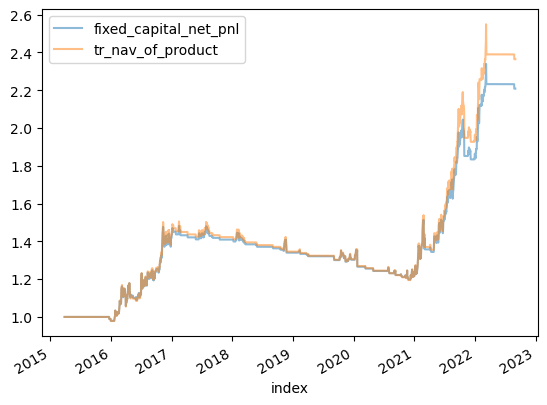

In [145]:
from ctse.sysdata.csv_ctse_strategy_backtest_data import csvCTSEStrategyBacktestData
from sysdata.csv.csv_multiple_prices import csvFuturesMultiplePricesData
import pandas as pd
import numpy as np
from ctse.sysobjects.ctse_strategy_backtest import ctseStrategyBacktest
from sysdata.csv.csv_instrument_data import csvFuturesInstrumentData
from itables import show
def select(se, start, end):
    return se[(se.index >= start) &(se.index <= end)]

ins = pd.Series(csvFuturesInstrumentData('ctse.data.csvconfig').get_list_of_instruments()).sample(1).iloc[0]
# ins = 'C'
print(ins)

notional_capital = 100_0000
rounding = True
'''
@ discrete system
@ open price time series
    | current period |--next price--| next period |

Time Index Symantics:
    Forecast: ex-ante
    Position: ex-post
    Transaction: ex-post, Position change
    PnL: ex-post
'''

meta_data = csvFuturesInstrumentData('ctse.data.csvconfig').get_instrument_data(ins).meta_data
pointsize = meta_data.Pointsize
transaction_cost_percentage = meta_data.Percentage
print(pointsize)
print(transaction_cost_percentage)

'''
Forecast
'''
backtest = csvCTSEStrategyBacktestData().read('1_B', ins, 'dma_long', cols=[ctseStrategyBacktest.STATE_FLAG, ctseStrategyBacktest.OPEN, ctseStrategyBacktest.CLOSE, ctseStrategyBacktest.OPERATE, ctseStrategyBacktest.NAV])
backtest.loc[:, 'forecast'] = backtest[ctseStrategyBacktest.STATE_FLAG].replace(np.nan, 0)
backtest.loc[:, 'entry_transaction'] = ((backtest.forecast.shift(1).diff() == 1) * 1)
backtest.loc[:, 'holding'] = backtest.forecast.shift(1)
backtest.loc[:, 'exit_transaction'] = ((backtest.forecast.shift(1).diff() == -1) * 1)
fill = backtest.loc[backtest[ctseStrategyBacktest.OPERATE].replace(np.nan, '').str.contains('止损')]
backtest.loc[fill.index, 'tr_fill_price'] = fill[ctseStrategyBacktest.OPERATE].apply(lambda s: float(s.split('_')[-1]))
backtest = backtest.drop(ctseStrategyBacktest.STATE_FLAG, axis=1)

contract = csvFuturesMultiplePricesData('ctse.data.multiple_prices_csv')._get_multiple_prices_without_checking(ins, check_data=False)[['PRICE_CONTRACT', 'PRICE', 'CLOSE', 'FORWARD_CLOSE']]
# rolling
# df.loc[df['FORWARD'].notna(), 'FORWARD'] = df['CLOSE']
# df.loc[df['FORWARD'].shift(-1).notna(), 'FORWARD'] = df.PRICE.shift(-1)
# df.loc[:, 'one_contract_rolling_cost'] = df['FORWARD_CLOSE'].diff().shift(-1) * df.CLOSE / df.FORWARD_CLOSE

df = pd.concat([backtest, contract], axis=1)

'''
Position Sizing
    0. ideal
    1. full notional capital
    2. no, rounding, continuous
'''
if rounding:
    df.loc[:, 'ideal_position'] = (
        ((df.holding == 1) * notional_capital // (df.PRICE * pointsize))
    )
else:
    df.loc[:, 'ideal_position'] = (
        ((df.holding == 1) * notional_capital / (df.PRICE * pointsize))
    )


'''
PnL
'''
## 1.entry transaction pnl
df.loc[:, 'fixed_capital_entry_transaction_pnl'] = (
    df.entry_transaction * df.ideal_position
    * df.PRICE * pointsize * -transaction_cost_percentage).shift(-1)

## 2.position pnl
### same contract
df.loc[:, 'one_same_contract_pnl'] = df.PRICE.shift(-1).diff() * pointsize
### rolling contract
df.loc[:, 'one_rolling_contract_pnl'] = (
    (contract.PRICE_CONTRACT != contract.PRICE_CONTRACT.shift(-1))
    * ((df.CLOSE - df.PRICE) + df.PRICE.shift(-1) - df.FORWARD_CLOSE) * pointsize
    )
### Fill Price for transcation
df.loc[:, 'Fill_Price'] = df.tr_fill_price / df[ctseStrategyBacktest.OPEN] * df.PRICE
df.loc[:, 'one_filled_contract_pnl'] = ((df['Fill_Price'] - df.PRICE) * pointsize)
### Actual Contract PnL
df.loc[:, 'one_actual_contract_pnl'] = df.one_same_contract_pnl
df.loc[df.one_rolling_contract_pnl.notna(), 'one_actual_contract_pnl'] = df.one_rolling_contract_pnl
df.loc[df.one_filled_contract_pnl.notna(), 'one_actual_contract_pnl'] = df.one_filled_contract_pnl
df.loc[:, 'fixed_capital_position_pnl'] = df.ideal_position * df.one_actual_contract_pnl

## 3.exit transaction pnl
df.loc[:, 'fixed_capital_exit_transaction_pnl'] = (
    df.exit_transaction * df.ideal_position.shift(1)
    * df.PRICE * pointsize * -transaction_cost_percentage).shift(-1)

df.loc[:, 'fixed_capital_net_pnl'] = (
    df.fixed_capital_entry_transaction_pnl.replace(np.nan, 0)
    + df.fixed_capital_position_pnl.replace(np.nan, 0)
    + df.fixed_capital_exit_transaction_pnl.replace(np.nan, 0)
    ).replace(np.nan, 0)
# df = df.loc[:, ctseStrategyBacktest.NAV] = column_nav


t1 = (df.fixed_capital_net_pnl / notional_capital)
# t1 = select(t1, '2020-12-01', '2021-02-01')0
t2 = df.tr_nav_of_product.pct_change()
# t2 = select(t2, '2020-12-01', '2021-02-01')
# t1.plot(legend=True)
# t2.plot()

start = '2010-07-01'
end = '2030-07-30'
# start = '2014-07-01'
# end = '2014-07-30'


(1+t1).cumprod().plot(legend=True, alpha=0.5)
(1+t2).cumprod().plot(legend=True, alpha=0.5)

# show(select(pd.concat([t1, t2], axis=1), start, end))

# # pretty
# column_nav = df.pop(ctseStrategyBacktest.NAV)
# df.loc[:, ctseStrategyBacktest.NAV] = column_nav
# show(select(df, start, end))

In [3]:
df.sort_values(['fixed_capital_net_pnl'], ascending=False)

df.loc[:, 'ideal_position'] = 0
df.loc[df.holding == 1, 'ideal_position'] = np.nan
df.loc[df.entry_transaction == 1, 'ideal_position'] = (df.entry_transaction * notional_capital / (df.PRICE * pointsize))
df.ideal_position.ffill(inplace=True)

## 2.rolling pnl
df.loc[:, 'one_contract_rolling_cost'] = (-df.FORWARD_CLOSE + df.CLOSE) * pointsize
df.loc[:, 'fixed_capital_rolling_pnl'] = (
    df.ideal_position * (df.ideal_position.shift(-1) != 0)
    * df.one_contract_rolling_cost
    )

,tr_the_open_price,tr_the_close_price,tr_operate,forecast,entry_transaction,holding,exit_transaction,tr_fill_price,PRICE_CONTRACT,PRICE,...,fixed_capital_rolling_pnl,one_same_contract_pnl,one_rolling_contract_pnl,Fill_Price,one_filled_contract_pnl,one_actual_contract_pnl,fixed_capital_position_pnl,fixed_capital_exit_transaction_pnl,fixed_capital_net_pnl,tr_nav_of_product
index,,,,,,,,,,,,,,,,,,,,,
2016-02-19,2294.909207,2277.247002,0_2258.064651082729,1.0,0.0,1.0,0.0,NaN,20160500,1949,...,143305.439331,-2890.0,-150.0,NaN,NaN,-150.0,-7845.188285,-0.0,135460.251046,1.068271
2014-07-14,2438.433121,2449.503185,0_2414.144514723069,1.0,0.0,1.0,0.0,NaN,20140900,2423,...,56397.306397,-1250.0,90.0,NaN,NaN,90.0,3787.878788,-0.0,60185.185185,1.023315
2016-11-10,2275.400473,2352.213356,0_2158.18137021043,1.0,0.0,1.0,0.0,NaN,20170100,1570,...,NaN,620.0,NaN,NaN,NaN,620.0,42494.859493,-0.0,42494.859493,1.191633
2020-07-27,2630.194196,2724.503948,0_2546.48677246099,1.0,0.0,1.0,0.0,NaN,20200900,2259,...,NaN,890.0,NaN,NaN,NaN,890.0,42020.774315,-0.0,42020.774315,1.345573
2020-08-14,2628.599721,2711.260090,0_2591.828072182247,1.0,0.0,1.0,0.0,NaN,20210100,2226,...,NaN,700.0,NaN,NaN,NaN,700.0,33050.047214,-0.0,33050.047214,1.334470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-22,2271.052574,2229.022884,0_2184.217479884595,1.0,0.0,1.0,0.0,NaN,20170100,1567,...,NaN,-430.0,NaN,NaN,NaN,-430.0,-27670.527671,-0.0,-27670.527671,1.039007
2017-12-04,2414.383666,2424.255562,0_2367.9344903724977,1.0,0.0,1.0,0.0,NaN,20180100,1712,...,-32544.378698,580.0,30.0,NaN,NaN,30.0,1775.147929,-0.0,-30769.230769,1.205088
2020-11-02,3098.582960,3014.741729,0_2961.1835680752597,1.0,0.0,1.0,0.0,NaN,20210100,2624,...,NaN,-690.0,NaN,NaN,NaN,-690.0,-32577.903683,-0.0,-32577.903683,1.485004
